In [ ]:
!pip install py_essentials
!pip install catalyst
!pip install efficientnet_pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import cv2
import statistics
import numpy as np
from scipy.stats import kurtosis, skew
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import PIL
from PIL import Image, ImageDraw
from py_essentials import hashing as hs
import seaborn as sns
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.metrics import f1_score 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import pickle
from catalyst import utils
from efficientnet_pytorch import EfficientNet


SEED = 42
utils.set_global_seed(SEED)

PyTorch Version:  1.11.0+cu113
Torchvision Version:  0.12.0+cu113
Pillow Version:  7.1.2
CUDA is available!  Training on GPU ...


In [ ]:
# Определяем на чем у нас будут производиться вычисления (cuda/cpu)
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')  

device(type='cuda', index=0)

In [ ]:
!nvidia-smi

Thu Jun  9 15:55:32 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P0    30W /  70W |   1398MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
!unzip -q /content/drive/MyDrive/simpsons/train.zip -d train
!unzip -q /content/drive/MyDrive/simpsons/testset.zip -d test

In [ ]:
BASE_DIR = Path('/content/drive/MyDrive/simpsons/')
TRAIN_DIR = Path('/content/train')
TEST_DIR = Path('/content/test')

In [ ]:
df_train = pd.read_csv(BASE_DIR/'df_train.csv', sep=',', index_col='index')

In [ ]:
# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']

In [ ]:
# Паддинг изображения
class SquarePad:
    def __call__(self, image):
        w, h = image.size
        max_wh = np.max([w, h])
        hp = int((max_wh - w) / 2)
        vp = int((max_wh - h) / 2)
        padding = (hp, vp, hp, vp)
        return F.pad(image, padding, 0, 'edge')

In [ ]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """

    def __init__(self, files, mode, rescale_size):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode
        self.rescale_size = rescale_size

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        if self.mode != 'train':
            transform = transforms.Compose([
                transforms.Resize(size=(self.rescale_size, self.rescale_size)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [
                                     0.229, 0.224, 0.225])
            ])
            x = self.load_sample(self.files[index])
            x = transform(x)
        else:
            transform = transforms.Compose([
                SquarePad(),  # pading
                transforms.Resize(size=(self.rescale_size, self.rescale_size)),
                transforms.CenterCrop(self.rescale_size * .9),
                transforms.RandomRotation(2.8),
                transforms.RandomChoice([
                    transforms.RandomHorizontalFlip(p=0.5),
                    # transforms.RandomPosterize(bits=2),
                    # transforms.RandomSolarize(threshold=192.0),
                    #transforms.RandomAdjustSharpness(.9, p=0.5),
                    transforms.ColorJitter(
                                        brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
                    transforms.RandomApply([transforms.RandomHorizontalFlip(
                        p=1), transforms.ColorJitter(contrast=0.9)], p=0.5),
                    transforms.RandomApply([transforms.RandomHorizontalFlip(
                        p=1), transforms.ColorJitter(brightness=0.1)], p=0.5),
                ]),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [
                                     0.229, 0.224, 0.225])
            ])
            x = self.load_sample(self.files[index])
            x = transform(x)

        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [ ]:
path_list = []
train_val_files = sorted(df_train['full_path'].tolist())
for elem in train_val_files:
    path_list.append(Path(elem))
train_val_files = path_list

test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [ ]:
train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25,
                                          stratify=train_val_labels)

In [ ]:
val_dataset = SimpsonsDataset(val_files, mode='val', rescale_size=224)
train_dataset = SimpsonsDataset(train_files, mode='train', rescale_size=224)

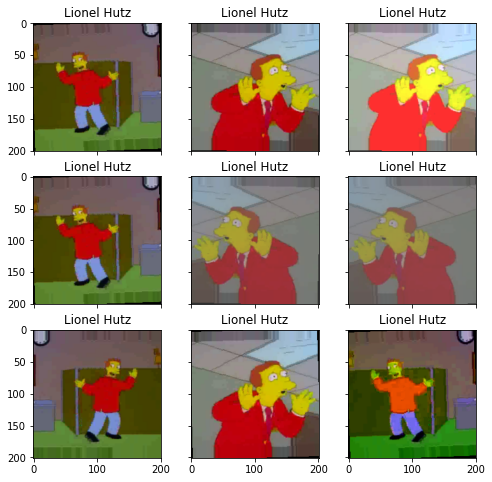

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(8, 8),
                       sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(8038, 8040))
    im_train, label = train_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),
                             train_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_train.data.cpu(),
           title=img_label, plt_ax=fig_x)

In [ ]:

train_labels = [path.parent.name for path in train_files]  # классы train
val_labels = [path.parent.name for path in val_files]     # классы val

In [ ]:
def create_dct_path_labels(train_files, train_labels):
    dct_simpsons = {}
    for label_i in np.unique(train_labels).tolist():
        dct_simpsons[label_i] = []

    for path_i, label_i in zip(train_files, train_labels):
        dct_simpsons[label_i].append(path_i)

    return dct_simpsons


def print_dct(dct_simpsons):
    for key in dct_simpsons:
        print(f"{key}\t{dct_simpsons[key]}")

In [ ]:

# Создадим словарь в котором ключами будут персонажи Симпсонов, а значениями списки с путями к картинкам.
dct_path_train = create_dct_path_labels(train_files, train_labels)

In [ ]:
# Дополним картинки классов у которых менее 100 картинок, до 100 картинок в классе
for person in dct_path_train:
    if len(dct_path_train[person]) < 100:
        dct_path_train[person] = dct_path_train[person] * \
            (100 // len(dct_path_train[person]))
        dct_path_train[person].extend(
            dct_path_train[person][:100 - len(dct_path_train[person])])

In [ ]:
def create_dct_from_labels(train_val_labels):
    """Функция создает из list train_val_labels, содержащего метки классов
    соответсвующим картинкам из выборки, словарь dict с ключами соответсвующими
    названиям классов, и значениями, соответвующими колчеству этих классов в 
    list train_val_labels"""
    dct_simpsons = {}
    for label_i in np.unique(train_val_labels).tolist():
        dct_simpsons.update({label_i: train_val_labels.count(label_i)})

    return dct_simpsons

In [ ]:
new_train_files = []

for person in dct_path_train:
    new_train_files.extend(dct_path_train[person])

new_train_label = [
    path.parent.name for path in new_train_files]  # классы train

# выведим на печать класс:количество картинок для train должно быть примерно 75 %
print_dct(create_dct_from_labels(new_train_label))

abraham_grampa_simpson	685
agnes_skinner	100
apu_nahasapeemapetilon	467
barney_gumble	100
bart_simpson	1006
carl_carlson	100
charles_montgomery_burns	895
chief_wiggum	739
cletus_spuckler	100
comic_book_guy	352
disco_stu	100
edna_krabappel	343
fat_tony	100
gil	100
groundskeeper_willie	100
homer_simpson	1684
kent_brockman	373
krusty_the_clown	904
lenny_leonard	233
lionel_hutz	100
lisa_simpson	1015
maggie_simpson	100
marge_simpson	968
martin_prince	100
mayor_quimby	185
milhouse_van_houten	809
miss_hoover	100
moe_szyslak	1089
ned_flanders	1090
nelson_muntz	269
otto_mann	100
patty_bouvier	100
principal_skinner	895
professor_john_frink	100
rainier_wolfcastle	100
ralph_wiggum	100
selma_bouvier	100
sideshow_bob	658
sideshow_mel	100
snake_jailbird	100
troy_mcclure	100
waylon_smithers	136


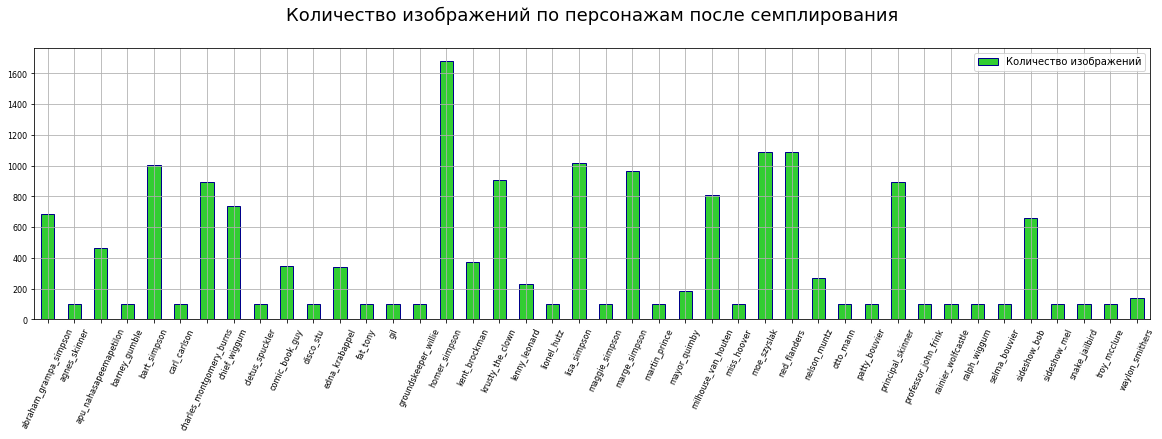

In [ ]:
df = pd.DataFrame(list(create_dct_from_labels(new_train_label).values()),
                  list(create_dct_from_labels(new_train_label).keys()))
df.columns = ['Количество изображений']
plot = df.plot.bar(
    figsize=(20, 5), fontsize=8, color='limegreen', edgecolor='darkblue', linewidth=1, 
    title='Количество изображений по персонажам после семплирования\n')
plot.title.set_size(18)
plot.legend(loc=1, fontsize=10)
plot.set(ylabel=None, xlabel=None)
plot.grid()
plt.xticks(rotation=65)
plt.show()

In [ ]:
# feature_extracting = False - вычисляем градиент у всей сети (обучаем всю модель)
# feature_extracting = True - обучаем только FC
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [ ]:
def initialize_model(model_name, feature_extract, use_pretrained=True):

    model_ft = None
    # Количество классов в датасете
    num_classes = len(os.listdir(TRAIN_DIR))

    if model_name == 'efficientnet-b0':
        """ efficientnet-b0
        """
        model_ft = EfficientNet.from_pretrained('efficientnet-b0')
        # отключает обновление градиентов у замороженных слоев
        set_parameter_requires_grad(model_ft, feature_extract)
        # получаем кол-во нейронов входящих в последний слой
        num_ftrs = model_ft._fc.in_features
        # меняем последний слой _fc на наш код
        model_ft._fc = nn.Sequential(
            nn.Linear(in_features=num_ftrs, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=num_classes)
        )

    elif model_name == 'efficientnet-b1':
        """ efficientnet-b1
        """
        model_ft = EfficientNet.from_pretrained('efficientnet-b1')
        # отключает обновление градиентов у замороженных слоев
        set_parameter_requires_grad(model_ft, feature_extract)
        # получаем кол-во нейронов входящих в последний слой
        num_ftrs = model_ft._fc.in_features
        # меняем последний слой _fc на наш код
        model_ft._fc = nn.Sequential(
            nn.Linear(in_features=num_ftrs, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=num_classes)
        )

    elif model_name == 'efficientnet-b2':
        """ efficientnet-b2
        """
        model_ft = EfficientNet.from_pretrained('efficientnet-b2')
        # отключает обновление градиентов у замороженных слоев
        set_parameter_requires_grad(model_ft, feature_extract)
        # получаем кол-во нейронов входящих в последний слой
        num_ftrs = model_ft._fc.in_features
        # меняем последний слой _fc на наш код
        model_ft._fc = nn.Sequential(
            nn.Linear(in_features=num_ftrs, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=num_classes)
        )

    elif model_name == 'efficientnet-b3':
        """ efficientnet-b3
        """
        model_ft = EfficientNet.from_pretrained('efficientnet-b3')
        # отключает обновление градиентов у замороженных слоев
        set_parameter_requires_grad(model_ft, feature_extract)
        # получаем кол-во нейронов входящих в последний слой
        num_ftrs = model_ft._fc.in_features
        # меняем последний слой _fc на наш код
        model_ft._fc = nn.Sequential(
            nn.Linear(in_features=num_ftrs, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=num_classes)
        )

    elif model_name == 'efficientnet-b4':
        """ efficientnet-b4
        """
        model_ft = EfficientNet.from_pretrained('efficientnet-b4')
        # отключает обновление градиентов у замороженных слоев
        set_parameter_requires_grad(model_ft, feature_extract)
        # получаем кол-во нейронов входящих в последний слой
        num_ftrs = model_ft._fc.in_features
        # меняем последний слой _fc на наш код
        model_ft._fc = nn.Sequential(
            nn.Linear(in_features=num_ftrs, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=num_classes)
        )

    elif model_name == 'resnet152':
        """ resnet152
        """
        model_ft = models.resnet152(pretrained=use_pretrained)
        # отключает обновление градиентов у замороженных слоев
        set_parameter_requires_grad(model_ft, feature_extract)
        # получаем кол-во нейронов входящих в последний слой
        num_ftrs = model_ft.fc.in_features
        # меняем последний слой _fc на наш код
        model_ft.fc = nn.Linear(num_ftrs, num_classes)

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft

In [ ]:
def model_learning(model_name, model_ft, rescale_size, batch_size):

    val_dataset = SimpsonsDataset(
        val_files, mode='val', rescale_size=rescale_size)
    new_train_dataset = SimpsonsDataset(
        new_train_files, mode='train', rescale_size=rescale_size)

    dataloaders = {'train': DataLoader(new_train_dataset, batch_size=batch_size, shuffle=True, num_workers=2),
                   'val': DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)}
    dataset_sizes = {'train': len(new_train_dataset), 'val': len(val_dataset)}

    # Базовая скорость обучения
    base_lr = 1e-3

    # Количество эпох
    num_epochs = 10

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model_ft.parameters(), lr=base_lr, betas=(
        0.0, 0.999), eps=1e-8, weight_decay=0, amsgrad=True)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(
        optimizer, milestones=[2, 4, 6, 8], gamma=0.8)

    accuracy = {"train": [], "val": []}

    for epoch in range(num_epochs):
        for k, dataloader in dataloaders.items():
            epoch_correct = 0
            epoch_all = 0
            for x_batch, y_batch in dataloader:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                if k == "train":
                    model_ft.train()
                    optimizer.zero_grad()
                    outp = model_ft(x_batch)
                else:
                    model_ft.eval()
                    with torch.no_grad():
                        outp = model_ft(x_batch)
                preds = outp.argmax(-1)
                correct = (preds.detach() == y_batch).sum(dim=0)
                all = y_batch.size(0)
                epoch_correct += correct.item()
                epoch_all += all
                if k == "train":
                    loss = criterion(outp, y_batch)
                    loss.backward()
                    optimizer.step()
            if k == "train":
                print(f"Epoch: {epoch+1}")
            print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
            accuracy[k].append(epoch_correct/epoch_all)
        scheduler.step()
    row = {'model': model_name, 'Acc_train': round(
        max(accuracy['train']), 3), 'Acc_val': round(max(accuracy['val']), 3)}
    torch.save(model_ft.state_dict(), Path(
        str(BASE_DIR) + str('/') + str(model_name)))

    # очистка кеша
    del model_ft
    del x_batch
    del y_batch
    torch.cuda.empty_cache()

    return(accuracy, row)

In [ ]:
# сбор статистики
df_model = pd.DataFrame()
df_accuracy = pd.DataFrame()

In [ ]:
model_name = 'efficientnet-b4'

accuracy_b4, row_b4 = model_learning(model_name,
                                     initialize_model(model_name,
                                                      feature_extract=False,
                                                      use_pretrained=True).to(device),
                                     rescale_size=EfficientNet.get_image_size(model_name), batch_size=16)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b4-6ed6700e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b4-6ed6700e.pth


  0%|          | 0.00/74.4M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b4
Epoch: 1
Loader: train. Accuracy: 0.8074464306854504
Loader: val. Accuracy: 0.9229887253965221
Epoch: 2
Loader: train. Accuracy: 0.9355392447022611
Loader: val. Accuracy: 0.9526084463978597
Epoch: 3
Loader: train. Accuracy: 0.9696341896531313
Loader: val. Accuracy: 0.962545385056373
Epoch: 4
Loader: train. Accuracy: 0.9798745116609447
Loader: val. Accuracy: 0.9657939996178101
Epoch: 5
Loader: train. Accuracy: 0.9872735882561856
Loader: val. Accuracy: 0.969998089050258
Epoch: 6
Loader: train. Accuracy: 0.9904107967325678
Loader: val. Accuracy: 0.9755398433021212
Epoch: 7
Loader: train. Accuracy: 0.9953829762045697
Loader: val. Accuracy: 0.9816548824765908
Epoch: 8
Loader: train. Accuracy: 0.9970995619746655
Loader: val. Accuracy: 0.9785973628893561
Epoch: 9
Loader: train. Accuracy: 0.9972179472001894
Loader: val. Accuracy: 0.9793617427861647
Epoch: 10
Loader: train. Accuracy: 0.9986977625192376
Loader: val. Accuracy: 0.9816548824765908


In [ ]:
# Сохранение статистик
for row in [row_b4]:
    df_model = df_model.append(row, ignore_index=True)

for accuracy in [accuracy_b4]:
    df_accuracy = df_accuracy.append(accuracy, ignore_index=True)

df_model.to_csv(BASE_DIR/'df_model.csv', sep=',', index_label='index')
df_accuracy.to_csv(BASE_DIR/'df_accuracy.csv', sep=',', index_label='index')

NameError: ignored

In [ ]:
df_model = pd.read_csv(BASE_DIR/'df_model.csv', sep=',', index_col='index')
df_accuracy = pd.read_csv(BASE_DIR/'df_accuracy.csv', sep=',', index_col='index')

In [ ]:
# Полученные максимальные показатели Accuracy (train/val) и f1-score на val-датасете
df_model.index = df_model['model']
df_model = df_model[['Acc_train', 'Acc_val']]
df_model

,Acc_train,Acc_val
model,,
efficientnet-b4,0.999,0.982


TypeError: ignored

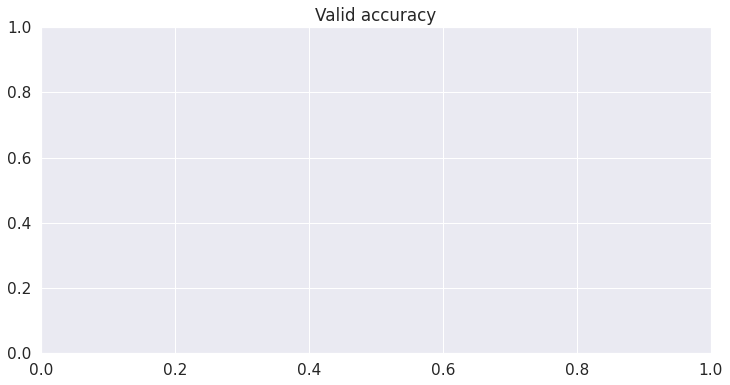

In [ ]:
# График валидационной accuracy.history при обучении моделей

sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(12, 6))
plt.title("Valid accuracy")
plt.plot(range(10), eval(df_accuracy['val']), label="EffNet-B4", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

In [ ]:
# График accuracy.history на train-датасете при обучении моделей

sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(12, 6))
plt.title("Train accuracy")
plt.plot(range(10), eval(df_accuracy['train'][1]), label="EffNet-B4", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

In [ ]:
model_name = 'efficientnet-b4'

model = initialize_model(model_name, feature_extract=False, use_pretrained=True).to(device)

rescale_size = EfficientNet.get_image_size(model_name)

val_dataset = SimpsonsDataset(val_files, mode='val', rescale_size=rescale_size)
new_train_dataset = SimpsonsDataset(
    new_train_files, mode='train', rescale_size=rescale_size)

model.load_state_dict(torch.load(
    Path(str(BASE_DIR) + str('/') + str(model_name))))
model.eval()

Loaded pretrained weights for efficientnet-b4


EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        48, 12, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        12, 48, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False
  

In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(device)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [ ]:
def predict_one_sample(model, img_tensor, device=device):
    with torch.no_grad():
        img_tensor = img_tensor.to(device)
        model.eval()
        y_hat = model(img_tensor).cpu()
        y_pred = torch.nn.functional.softmax(y_hat, dim=1).numpy()
    return y_pred

In [ ]:
def make_f1_score(model, n=len(val_dataset)):

    idxs = list(map(int, np.random.uniform(0, n, n)))
    imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

    probs_ims = predict(model, imgs)
    y_pred = np.argmax(probs_ims, -1)

    actual_labels = [val_dataset[id][1] for id in idxs]
    preds_class = list(y_pred)

    return round(f1_score(actual_labels, preds_class, average='micro'), 3).tolist()

In [ ]:
# Расчет f1_score на валидационном датасете
f1_val = make_f1_score(model)
f1_val

NameError: ignored

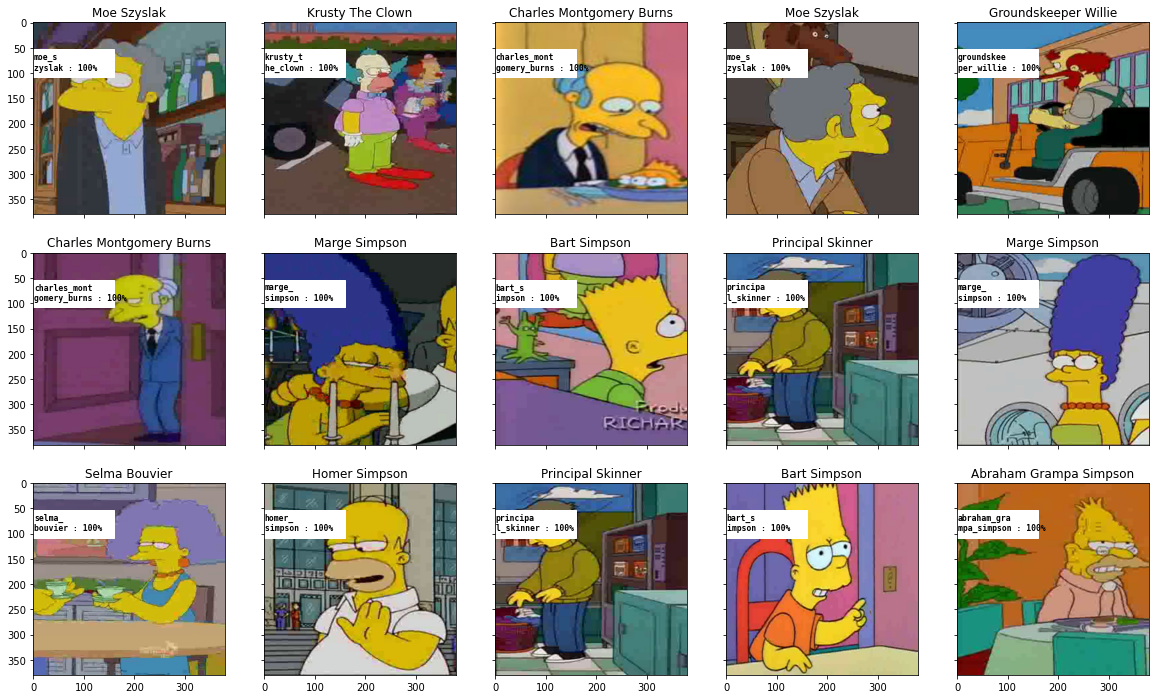

In [ ]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

fig, ax = plt.subplots(nrows=3, ncols=5, figsize=(20, 12),
                       sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0, 5000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),
                             val_dataset.label_encoder.inverse_transform([label])[0].split('_')))

    imshow(im_val.data.cpu(),
           title=img_label, plt_ax=fig_x)

    actual_text = "Actual : {}".format(img_label)

    fig_x.add_patch(patches.Rectangle((0, 53), 160, 55, color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("monospace")
    prob_pred = predict_one_sample(model, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)

    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(
        predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label, predicted_proba)

    fig_x.text(1, 59, predicted_text, horizontalalignment='left', fontproperties=font,
               verticalalignment='top', fontsize=8, color='black', fontweight='bold')

In [ ]:
def confusion_matrix():
    # вытащим настоящие лейблы!
    actual = [val_dataset[i][1] for i in range(len(val_dataset))]
    
    # вытащим картинки, чтобы их подать в даталоадер, а потом классификатору
    image = [val_dataset[i][0] for i in range( len(val_dataset) ) ]
    
    # подготовим даталоадер
    img_conf_dataloader = torch.utils.data.DataLoader(image, batch_size=16, shuffle=False, num_workers=2)
    
    # вытащим предсказанные лейблы
    probs = predict(model, img_conf_dataloader)
    preds = np.argmax(probs, axis=1)
    
    # создадим таблицу, где в одном столбце будут нстоящие метки, во втором предсказанные
    df = pd.DataFrame({'actual': actual, 'preds': preds})
    
    # margins = False - чтобы не было строки all
    confusion_matrix = pd.crosstab(df['actual'], df['preds'], rownames=['Actual'], colnames=['Predicted'], margins = False)
    
    # загрузим наш инкодер
    label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))
    
    # получим список классов
    # label_encoder.classes_[i] - можно убедиться, какому классу, какое кодированное число какому классу соответствует
    yticklabels = label_encoder.classes_
    
    plt.subplots(figsize=(20,20))

    sns.heatmap(confusion_matrix, annot=True, fmt="d", linewidths=0.5, cmap="YlGnBu", cbar=False, vmax = 30, yticklabels = yticklabels, xticklabels = yticklabels);


In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test", rescale_size=rescale_size)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model, test_loader)

label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))
preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [ ]:
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [ ]:

my_submit.to_csv(BASE_DIR/'simpsons_submit.csv', index=False)